In [1]:
import os
import sys
import random
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from keras.layers import Conv1D
from tqdm import tqdm_notebook as tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.layers.normalization import BatchNormalization
from keras.models import Model, load_model
from keras.layers import Activation
from keras.layers import Input
from keras.layers import Dense
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from PIL import Image
from keras import backend as K
K.tensorflow_backend._get_available_gpus()



Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1457349867334788948
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9120835829
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9469667347014641807
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


The goal of this project is the automatice prediction of lesion segmentation boundaries within dermoscopic images. 
I have decided to use Keras as it as an easy prototyping deep learning library, my segmentation model will be base on the famouse medical imaging segmentation by Olaf Ronneberger "U-Net: Convolutional Networks for Biomedical Image Segmentation"(https://arxiv.org/abs/1505.04597)


In [3]:
rows, cols = 256,256
dct = {'pigment': 0, 'negative': 1, 'streaks': 2, 'milia': 3, 'globules': 4}

MASK_PATH ='data_task2/gt_256/'
Image_PATH='data_task2/org_256/'
# mask = np.zeros((5, rows, cols), dtype=np.bool) # Ray - removed, not required
image_ids = next(os.walk(Image_PATH))[2]
mask_ids = next(os.walk(MASK_PATH))[2]
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [4]:
image_ids = next(os.walk(Image_PATH))[2]
mask_ids = next(os.walk(MASK_PATH))[2]

print(mask_ids[0:6])


['ISIC_0000000_attribute_globules.png', 'ISIC_0000000_attribute_milia_like_cyst.png', 'ISIC_0000000_attribute_negative_network.png', 'ISIC_0000000_attribute_pigment_network.png', 'ISIC_0000000_attribute_streaks.png', 'ISIC_0000001_attribute_globules.png']


In [5]:
#Y_train = np.zeros((len(mask_ids),5, rows, cols), dtype= np.uint8)
names = ['_attribute_globules.png','_attribute_pigment_network.png', '_attribute_milia_like_cyst.png', '_attribute_negative_network.png', '_attribute_streaks.png']
Y_train = np.zeros((len(image_ids), rows, cols, 5),  dtype=np.bool) # Ray - changed
print(Y_train.shape)
for n, id_ in enumerate(image_ids):
    ls = id_.split('.')
    for i in range(len(names)):
            im = cv2.imread('data_task2/gt_256/'+ ls[0]+names[i], 0)
            Y_train[n, :, :, i] = im
            
            

(2520, 256, 256, 5)


In [6]:
image_ids[1]


'ISIC_0000001.jpg'

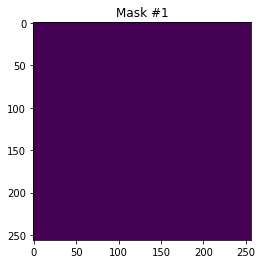

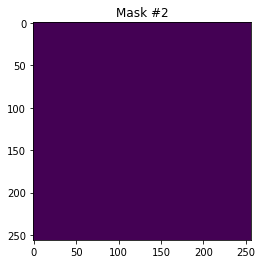

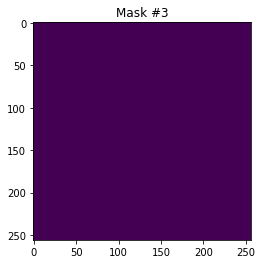

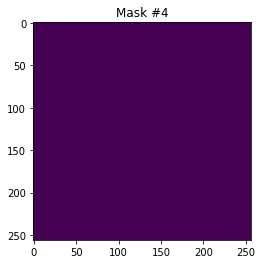

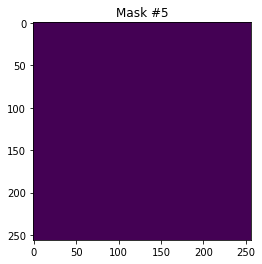

In [7]:
#for i, m in enumerate(Y_train[3]):
for i in range(Y_train.shape[-1]):
    plt.figure()
    #plt.imshow(255*(m.astype(np.uint8)))
    # Change by Ray
    plt.imshow(255*(Y_train[3,:,:,i].astype(np.uint8)))
    plt.title('Mask #{}'.format(i + 1))
    plt.show()

Since Mask images are encoded as single-channel (grayscale) 8-bit PNGs , where each pixel is either:
0: representing the background of the image, or areas outside the primary lesion
255: representing the foreground of the image; a dummy numpy array is created with and a bool variable to show whether that pixel is a lesion or not.

In [8]:
X_train = np.zeros((len(image_ids), 256,256,1), dtype=np.float32)
for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
    im = cv2.imread('data_task2/org_256/'+ id_,0)
    im= np.expand_dims(im, axis = -1)
    X_train[n] = im
 

In [9]:

X_train.shape

print(Y_train.shape, X_train.shape)
print(X_train[1])



(2520, 256, 256, 5) (2520, 256, 256, 1)
[[[134.]
  [129.]
  [129.]
  ...
  [149.]
  [143.]
  [155.]]

 [[134.]
  [130.]
  [131.]
  ...
  [152.]
  [142.]
  [148.]]

 [[131.]
  [128.]
  [129.]
  ...
  [152.]
  [141.]
  [143.]]

 ...

 [[162.]
  [162.]
  [164.]
  ...
  [174.]
  [171.]
  [174.]]

 [[162.]
  [163.]
  [165.]
  ...
  [173.]
  [170.]
  [174.]]

 [[167.]
  [167.]
  [168.]
  ...
  [174.]
  [173.]
  [177.]]]


All the images of training, Mask, Validation, and test folder,  are read into the numpy arrays and resized and fed into the relevent dummy matrix created earlier. Also All resized images are saved to be used as 

In [10]:

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

# Loss funtion
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [11]:
###For each image, a pixel-wise comparison of each predicted segmentation with the corresponding ground truth segmentation\
###is made using the Jaccard index.

def jaccard(y_true, y_pred, smooth=1.):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def lossfunc(y_true, y_pred):
    return - 1 * jaccard(y_true, y_pred)
    # return - 0.7 * jaccard(y_true, y_pred) - 0.3 * dice(y_true, y_pred)

    
def depth_softmax(matrix):
    sigmoid = lambda x: 1 / (1 + K.exp(-x))
    sigmoided_matrix = sigmoid(matrix)
    softmax_matrix = sigmoided_matrix / K.sum(sigmoided_matrix, axis=0)
    return softmax_matrix    
    
 

In [12]:
### Unet model from https://github.com/zhixuhao/unet
from keras.layers import Reshape, Permute
def unet():
    #inputs = Input((128, 128, 5))
    # Change by Ray
    inputs = Input((256,256, 1)) # Image is only single channel
    s = Lambda(lambda x: x / 255) (inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization(axis=3)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization(axis=3)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization(axis=3)(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization(axis=3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) 
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization(axis=3)(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization(axis=3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(Dropout(0.2)(conv4))
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization(axis=3)(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization(axis=3)(conv5)
    
    middle = Dropout(0.2)(conv5)
    

    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D()(middle)) 
    up6 = BatchNormalization(axis=3)(up6) 
    concat6 = concatenate([conv4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(concat6)
    conv6 = BatchNormalization(axis=3)(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization(axis=3)(conv6)
   
   
    
    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D()(conv6))
    up7 = BatchNormalization(axis=3)(up7)
    concat7 = concatenate([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(concat7)
    conv7 = BatchNormalization(axis=3)(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization(axis=3)(conv7)

    
    
    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D()(conv7)) 
    up8 = BatchNormalization(axis=3)(up8)
    concat8 = concatenate([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(concat8)
    conv8 = BatchNormalization(axis=3)(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization(axis=3)(conv8)

    
    
    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D()(conv8)) 
    up9 = BatchNormalization(axis=3)(up9)
    concat9 = concatenate([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(concat9)
    conv9 = BatchNormalization(axis=3)(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization(axis=3)(conv9)

   
    output=Conv2D(5, 1, 1, activation=depth_softmax)(conv9)
    print(output.shape)
        
    #output = Conv2D(5, 1, border_mode='same', activation='softmax')(conv9)
    #o_shape = output._keras_shape
    #print(o_shape)
    #outputHeight = o_shape[1]
    #outputWidth = o_shape[2]

    #o = (Reshape((  5 , outputHeight*outputWidth   )))(conv10)
    #o = (Permute((2, 1)))(o)
    #o = (Activation('softmax'))(o)
    ##print(output._keras_shape)
    #output = Reshape((32, rows, cols, 5))(o)
    #print(output._keras_shape)
    
    model = Model(inputs=[inputs], outputs=[ output])
    
    model.compile(optimizer=RMSprop(lr=0.01,  rho=0.9),loss='categorical_crossentropy', metrics=[jaccard])

    return model

In [13]:
# Y_train.shape
# Y_train = Y_train.transpose((0, 3, 2, 1))
# Y_train.shape
# Change by Ray - no need

In [14]:
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau
model = unet()

lr_scheduler =ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_jaccard', mode='max', verbose=1, patience=10)
checkpoint = ModelCheckpoint('task2.h5', monitor  = 'val_jaccard' , verbose=1, save_best_only=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\sahan\Anaconda3\lib\site-packages\ipykernel\__main__.py:79: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(5, (1, 1), activation=<function ...)`


(?, 256, 256, 5)


In [15]:
print(X_train.shape, Y_train.shape)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, shuffle=False, epochs=100,
                    callbacks=[early_stopping, checkpoint, lr_scheduler])

(2520, 256, 256, 1) (2520, 256, 256, 5)
Instructions for updating:
Use tf.cast instead.
Train on 2268 samples, validate on 252 samples
Epoch 1/100


1512/2268 [===================>..........] - ETA: 33:27 - loss: 0.1526 - jaccard: 0.01 - ETA: 17:18 - loss: 0.1681 - jaccard: 0.01 - ETA: 11:55 - loss: 0.1354 - jaccard: 0.01 - ETA: 9:13 - loss: 0.1406 - jaccard: 0.0167 - ETA: 7:36 - loss: 0.1565 - jaccard: 0.018 - ETA: 6:31 - loss: 0.1730 - jaccard: 0.021 - ETA: 5:45 - loss: 0.1629 - jaccard: 0.022 - ETA: 5:10 - loss: 0.1581 - jaccard: 0.023 - ETA: 4:43 - loss: 0.1644 - jaccard: 0.025 - ETA: 4:21 - loss: 0.1585 - jaccard: 0.025 - ETA: 4:03 - loss: 0.1528 - jaccard: 0.024 - ETA: 3:48 - loss: 0.1458 - jaccard: 0.023 - ETA: 3:35 - loss: 0.1454 - jaccard: 0.024 - ETA: 3:24 - loss: 0.1395 - jaccard: 0.023 - ETA: 3:15 - loss: 0.1339 - jaccard: 0.022 - ETA: 3:06 - loss: 0.1310 - jaccard: 0.022 - ETA: 2:59 - loss: 0.1273 - jaccard: 0.021 - ETA: 2:52 - loss: 0.1253 - jaccard: 0.021 - ETA: 2:46 - loss: 0.1269 - jaccard: 0.021 - ETA: 2:41 - loss: 0.1231 - jaccard: 0.021 - ETA: 2:36 - loss: 0.1176 - jaccard: 0.020 - ETA: 2:32 - loss: 0.1296 - jac

2268/2268 [==============================] - ETA: 28s - loss: 0.0610 - jaccard: 0.00 - ETA: 28s - loss: 0.0607 - jaccard: 0.00 - ETA: 28s - loss: 0.0605 - jaccard: 0.00 - ETA: 27s - loss: 0.0602 - jaccard: 0.00 - ETA: 27s - loss: 0.0600 - jaccard: 0.00 - ETA: 27s - loss: 0.0598 - jaccard: 0.00 - ETA: 26s - loss: 0.0595 - jaccard: 0.00 - ETA: 26s - loss: 0.0593 - jaccard: 0.00 - ETA: 26s - loss: 0.0590 - jaccard: 0.00 - ETA: 25s - loss: 0.0589 - jaccard: 0.00 - ETA: 25s - loss: 0.0589 - jaccard: 0.00 - ETA: 25s - loss: 0.0587 - jaccard: 0.00 - ETA: 24s - loss: 0.0585 - jaccard: 0.00 - ETA: 24s - loss: 0.0583 - jaccard: 0.00 - ETA: 24s - loss: 0.0580 - jaccard: 0.00 - ETA: 24s - loss: 0.0580 - jaccard: 0.00 - ETA: 23s - loss: 0.0577 - jaccard: 0.00 - ETA: 23s - loss: 0.0576 - jaccard: 0.00 - ETA: 23s - loss: 0.0574 - jaccard: 0.00 - ETA: 22s - loss: 0.0572 - jaccard: 0.00 - ETA: 22s - loss: 0.0570 - jaccard: 0.00 - ETA: 22s - loss: 0.0569 - jaccard: 0.00 - ETA: 21s - loss: 0.0567 - jacca

1528/2268 [===================>..........] - ETA: 1:37 - loss: 0.0753 - jaccard: 0.011 - ETA: 1:26 - loss: 0.0829 - jaccard: 0.011 - ETA: 1:23 - loss: 0.0654 - jaccard: 0.011 - ETA: 1:21 - loss: 0.0780 - jaccard: 0.012 - ETA: 1:20 - loss: 0.0865 - jaccard: 0.013 - ETA: 1:19 - loss: 0.0974 - jaccard: 0.014 - ETA: 1:18 - loss: 0.0961 - jaccard: 0.014 - ETA: 1:17 - loss: 0.0981 - jaccard: 0.015 - ETA: 1:17 - loss: 0.1095 - jaccard: 0.016 - ETA: 1:16 - loss: 0.1089 - jaccard: 0.015 - ETA: 1:16 - loss: 0.1059 - jaccard: 0.015 - ETA: 1:16 - loss: 0.1015 - jaccard: 0.014 - ETA: 1:15 - loss: 0.1025 - jaccard: 0.014 - ETA: 1:15 - loss: 0.0987 - jaccard: 0.014 - ETA: 1:15 - loss: 0.0970 - jaccard: 0.013 - ETA: 1:14 - loss: 0.0969 - jaccard: 0.013 - ETA: 1:14 - loss: 0.0952 - jaccard: 0.012 - ETA: 1:13 - loss: 0.0953 - jaccard: 0.012 - ETA: 1:13 - loss: 0.0980 - jaccard: 0.011 - ETA: 1:13 - loss: 0.0956 - jaccard: 0.011 - ETA: 1:12 - loss: 0.0914 - jaccard: 0.011 - ETA: 1:12 - loss: 0.1033 - jacc

2268/2268 [==============================] - ETA: 25s - loss: 0.0516 - jaccard: 0.00 - ETA: 24s - loss: 0.0514 - jaccard: 0.00 - ETA: 24s - loss: 0.0513 - jaccard: 0.00 - ETA: 24s - loss: 0.0511 - jaccard: 0.00 - ETA: 23s - loss: 0.0509 - jaccard: 0.00 - ETA: 23s - loss: 0.0507 - jaccard: 0.00 - ETA: 23s - loss: 0.0505 - jaccard: 0.00 - ETA: 23s - loss: 0.0503 - jaccard: 0.00 - ETA: 22s - loss: 0.0504 - jaccard: 0.00 - ETA: 22s - loss: 0.0502 - jaccard: 0.00 - ETA: 22s - loss: 0.0500 - jaccard: 0.00 - ETA: 22s - loss: 0.0498 - jaccard: 0.00 - ETA: 21s - loss: 0.0496 - jaccard: 0.00 - ETA: 21s - loss: 0.0496 - jaccard: 0.00 - ETA: 21s - loss: 0.0495 - jaccard: 0.00 - ETA: 20s - loss: 0.0494 - jaccard: 0.00 - ETA: 20s - loss: 0.0492 - jaccard: 0.00 - ETA: 20s - loss: 0.0491 - jaccard: 0.00 - ETA: 20s - loss: 0.0489 - jaccard: 0.00 - ETA: 19s - loss: 0.0488 - jaccard: 0.00 - ETA: 19s - loss: 0.0486 - jaccard: 0.00 - ETA: 19s - loss: 0.0484 - jaccard: 0.00 - ETA: 18s - loss: 0.0483 - jacca

1528/2268 [===================>..........] - ETA: 1:15 - loss: 0.0687 - jaccard: 0.006 - ETA: 1:15 - loss: 0.0709 - jaccard: 0.007 - ETA: 1:15 - loss: 0.0571 - jaccard: 0.007 - ETA: 1:14 - loss: 0.0712 - jaccard: 0.008 - ETA: 1:13 - loss: 0.0752 - jaccard: 0.008 - ETA: 1:12 - loss: 0.0868 - jaccard: 0.010 - ETA: 1:13 - loss: 0.0846 - jaccard: 0.011 - ETA: 1:12 - loss: 0.0854 - jaccard: 0.011 - ETA: 1:12 - loss: 0.1006 - jaccard: 0.012 - ETA: 1:12 - loss: 0.0999 - jaccard: 0.012 - ETA: 1:11 - loss: 0.0974 - jaccard: 0.011 - ETA: 1:11 - loss: 0.0929 - jaccard: 0.011 - ETA: 1:10 - loss: 0.0937 - jaccard: 0.011 - ETA: 1:10 - loss: 0.0908 - jaccard: 0.011 - ETA: 1:10 - loss: 0.0885 - jaccard: 0.010 - ETA: 1:10 - loss: 0.0882 - jaccard: 0.010 - ETA: 1:10 - loss: 0.0874 - jaccard: 0.009 - ETA: 1:10 - loss: 0.0867 - jaccard: 0.009 - ETA: 1:12 - loss: 0.0888 - jaccard: 0.009 - ETA: 1:13 - loss: 0.0866 - jaccard: 0.009 - ETA: 1:13 - loss: 0.0828 - jaccard: 0.008 - ETA: 1:13 - loss: 0.0925 - jacc

2268/2268 [==============================] - ETA: 25s - loss: 0.0495 - jaccard: 0.00 - ETA: 24s - loss: 0.0494 - jaccard: 0.00 - ETA: 24s - loss: 0.0492 - jaccard: 0.00 - ETA: 24s - loss: 0.0491 - jaccard: 0.00 - ETA: 24s - loss: 0.0488 - jaccard: 0.00 - ETA: 23s - loss: 0.0486 - jaccard: 0.00 - ETA: 23s - loss: 0.0484 - jaccard: 0.00 - ETA: 23s - loss: 0.0483 - jaccard: 0.00 - ETA: 23s - loss: 0.0483 - jaccard: 0.00 - ETA: 22s - loss: 0.0482 - jaccard: 0.00 - ETA: 22s - loss: 0.0480 - jaccard: 0.00 - ETA: 22s - loss: 0.0478 - jaccard: 0.00 - ETA: 21s - loss: 0.0476 - jaccard: 0.00 - ETA: 21s - loss: 0.0476 - jaccard: 0.00 - ETA: 21s - loss: 0.0475 - jaccard: 0.00 - ETA: 21s - loss: 0.0474 - jaccard: 0.00 - ETA: 20s - loss: 0.0472 - jaccard: 0.00 - ETA: 20s - loss: 0.0471 - jaccard: 0.00 - ETA: 20s - loss: 0.0469 - jaccard: 0.00 - ETA: 20s - loss: 0.0468 - jaccard: 0.00 - ETA: 19s - loss: 0.0467 - jaccard: 0.00 - ETA: 19s - loss: 0.0465 - jaccard: 0.00 - ETA: 19s - loss: 0.0464 - jacca

1528/2268 [===================>..........] - ETA: 1:18 - loss: 0.0705 - jaccard: 0.005 - ETA: 1:34 - loss: 0.0794 - jaccard: 0.007 - ETA: 1:38 - loss: 0.0627 - jaccard: 0.007 - ETA: 1:40 - loss: 0.0750 - jaccard: 0.008 - ETA: 1:46 - loss: 0.0841 - jaccard: 0.009 - ETA: 1:44 - loss: 0.0931 - jaccard: 0.010 - ETA: 1:39 - loss: 0.0930 - jaccard: 0.011 - ETA: 1:36 - loss: 0.0949 - jaccard: 0.011 - ETA: 1:34 - loss: 0.1059 - jaccard: 0.012 - ETA: 1:32 - loss: 0.1016 - jaccard: 0.011 - ETA: 1:30 - loss: 0.0991 - jaccard: 0.011 - ETA: 1:28 - loss: 0.0948 - jaccard: 0.011 - ETA: 1:27 - loss: 0.0961 - jaccard: 0.011 - ETA: 1:26 - loss: 0.0924 - jaccard: 0.010 - ETA: 1:25 - loss: 0.0904 - jaccard: 0.010 - ETA: 1:24 - loss: 0.0908 - jaccard: 0.010 - ETA: 1:23 - loss: 0.0900 - jaccard: 0.009 - ETA: 1:24 - loss: 0.0895 - jaccard: 0.009 - ETA: 1:25 - loss: 0.0914 - jaccard: 0.009 - ETA: 1:25 - loss: 0.0895 - jaccard: 0.009 - ETA: 1:24 - loss: 0.0856 - jaccard: 0.008 - ETA: 1:23 - loss: 0.0977 - jacc

2268/2268 [==============================] - ETA: 25s - loss: 0.0492 - jaccard: 0.00 - ETA: 25s - loss: 0.0491 - jaccard: 0.00 - ETA: 25s - loss: 0.0489 - jaccard: 0.00 - ETA: 24s - loss: 0.0488 - jaccard: 0.00 - ETA: 24s - loss: 0.0485 - jaccard: 0.00 - ETA: 24s - loss: 0.0483 - jaccard: 0.00 - ETA: 24s - loss: 0.0481 - jaccard: 0.00 - ETA: 23s - loss: 0.0480 - jaccard: 0.00 - ETA: 23s - loss: 0.0480 - jaccard: 0.00 - ETA: 23s - loss: 0.0479 - jaccard: 0.00 - ETA: 22s - loss: 0.0477 - jaccard: 0.00 - ETA: 22s - loss: 0.0475 - jaccard: 0.00 - ETA: 22s - loss: 0.0473 - jaccard: 0.00 - ETA: 22s - loss: 0.0473 - jaccard: 0.00 - ETA: 21s - loss: 0.0471 - jaccard: 0.00 - ETA: 21s - loss: 0.0470 - jaccard: 0.00 - ETA: 21s - loss: 0.0469 - jaccard: 0.00 - ETA: 20s - loss: 0.0468 - jaccard: 0.00 - ETA: 20s - loss: 0.0466 - jaccard: 0.00 - ETA: 20s - loss: 0.0465 - jaccard: 0.00 - ETA: 20s - loss: 0.0463 - jaccard: 0.00 - ETA: 19s - loss: 0.0462 - jaccard: 0.00 - ETA: 19s - loss: 0.0460 - jacca

1536/2268 [===================>..........] - ETA: 1:14 - loss: 0.0725 - jaccard: 0.004 - ETA: 1:14 - loss: 0.0766 - jaccard: 0.004 - ETA: 1:14 - loss: 0.0626 - jaccard: 0.005 - ETA: 1:13 - loss: 0.0757 - jaccard: 0.006 - ETA: 1:13 - loss: 0.0806 - jaccard: 0.007 - ETA: 1:13 - loss: 0.0895 - jaccard: 0.008 - ETA: 1:13 - loss: 0.0912 - jaccard: 0.008 - ETA: 1:12 - loss: 0.0911 - jaccard: 0.009 - ETA: 1:12 - loss: 0.1063 - jaccard: 0.010 - ETA: 1:12 - loss: 0.1031 - jaccard: 0.010 - ETA: 1:12 - loss: 0.1013 - jaccard: 0.010 - ETA: 1:11 - loss: 0.0966 - jaccard: 0.009 - ETA: 1:11 - loss: 0.0983 - jaccard: 0.010 - ETA: 1:11 - loss: 0.0946 - jaccard: 0.009 - ETA: 1:11 - loss: 0.0921 - jaccard: 0.008 - ETA: 1:10 - loss: 0.0916 - jaccard: 0.008 - ETA: 1:10 - loss: 0.0908 - jaccard: 0.008 - ETA: 1:10 - loss: 0.0897 - jaccard: 0.008 - ETA: 1:10 - loss: 0.0906 - jaccard: 0.008 - ETA: 1:09 - loss: 0.0887 - jaccard: 0.007 - ETA: 1:09 - loss: 0.0848 - jaccard: 0.007 - ETA: 1:09 - loss: 0.0960 - jacc

2268/2268 [==============================] - ETA: 24s - loss: 0.0474 - jaccard: 0.00 - ETA: 23s - loss: 0.0473 - jaccard: 0.00 - ETA: 23s - loss: 0.0472 - jaccard: 0.00 - ETA: 23s - loss: 0.0469 - jaccard: 0.00 - ETA: 23s - loss: 0.0467 - jaccard: 0.00 - ETA: 22s - loss: 0.0466 - jaccard: 0.00 - ETA: 22s - loss: 0.0464 - jaccard: 0.00 - ETA: 22s - loss: 0.0464 - jaccard: 0.00 - ETA: 22s - loss: 0.0463 - jaccard: 0.00 - ETA: 21s - loss: 0.0461 - jaccard: 0.00 - ETA: 21s - loss: 0.0459 - jaccard: 0.00 - ETA: 21s - loss: 0.0458 - jaccard: 0.00 - ETA: 21s - loss: 0.0458 - jaccard: 0.00 - ETA: 20s - loss: 0.0456 - jaccard: 0.00 - ETA: 20s - loss: 0.0455 - jaccard: 0.00 - ETA: 20s - loss: 0.0454 - jaccard: 0.00 - ETA: 19s - loss: 0.0452 - jaccard: 0.00 - ETA: 19s - loss: 0.0451 - jaccard: 0.00 - ETA: 19s - loss: 0.0450 - jaccard: 0.00 - ETA: 19s - loss: 0.0448 - jaccard: 0.00 - ETA: 18s - loss: 0.0447 - jaccard: 0.00 - ETA: 18s - loss: 0.0445 - jaccard: 0.00 - ETA: 18s - loss: 0.0444 - jacca

1536/2268 [===================>..........] - ETA: 1:14 - loss: 0.0693 - jaccard: 0.002 - ETA: 1:14 - loss: 0.0681 - jaccard: 0.003 - ETA: 1:13 - loss: 0.0569 - jaccard: 0.003 - ETA: 1:13 - loss: 0.0707 - jaccard: 0.004 - ETA: 1:13 - loss: 0.0751 - jaccard: 0.004 - ETA: 1:13 - loss: 0.0833 - jaccard: 0.006 - ETA: 1:12 - loss: 0.0821 - jaccard: 0.006 - ETA: 1:12 - loss: 0.0816 - jaccard: 0.007 - ETA: 1:12 - loss: 0.0975 - jaccard: 0.009 - ETA: 1:12 - loss: 0.0953 - jaccard: 0.009 - ETA: 1:11 - loss: 0.0940 - jaccard: 0.009 - ETA: 1:11 - loss: 0.0900 - jaccard: 0.008 - ETA: 1:11 - loss: 0.0901 - jaccard: 0.008 - ETA: 1:10 - loss: 0.0869 - jaccard: 0.008 - ETA: 1:10 - loss: 0.0846 - jaccard: 0.007 - ETA: 1:10 - loss: 0.0846 - jaccard: 0.007 - ETA: 1:10 - loss: 0.0845 - jaccard: 0.007 - ETA: 1:09 - loss: 0.0837 - jaccard: 0.007 - ETA: 1:09 - loss: 0.0847 - jaccard: 0.007 - ETA: 1:09 - loss: 0.0829 - jaccard: 0.007 - ETA: 1:09 - loss: 0.0793 - jaccard: 0.006 - ETA: 1:08 - loss: 0.0906 - jacc

2268/2268 [==============================] - ETA: 23s - loss: 0.0464 - jaccard: 0.00 - ETA: 23s - loss: 0.0463 - jaccard: 0.00 - ETA: 23s - loss: 0.0462 - jaccard: 0.00 - ETA: 23s - loss: 0.0459 - jaccard: 0.00 - ETA: 22s - loss: 0.0457 - jaccard: 0.00 - ETA: 22s - loss: 0.0456 - jaccard: 0.00 - ETA: 22s - loss: 0.0454 - jaccard: 0.00 - ETA: 22s - loss: 0.0454 - jaccard: 0.00 - ETA: 21s - loss: 0.0453 - jaccard: 0.00 - ETA: 21s - loss: 0.0451 - jaccard: 0.00 - ETA: 21s - loss: 0.0450 - jaccard: 0.00 - ETA: 20s - loss: 0.0448 - jaccard: 0.00 - ETA: 20s - loss: 0.0448 - jaccard: 0.00 - ETA: 20s - loss: 0.0446 - jaccard: 0.00 - ETA: 20s - loss: 0.0445 - jaccard: 0.00 - ETA: 19s - loss: 0.0444 - jaccard: 0.00 - ETA: 19s - loss: 0.0443 - jaccard: 0.00 - ETA: 19s - loss: 0.0441 - jaccard: 0.00 - ETA: 19s - loss: 0.0440 - jaccard: 0.00 - ETA: 18s - loss: 0.0439 - jaccard: 0.00 - ETA: 18s - loss: 0.0437 - jaccard: 0.00 - ETA: 18s - loss: 0.0436 - jaccard: 0.00 - ETA: 18s - loss: 0.0435 - jacca

1536/2268 [===================>..........] - ETA: 1:14 - loss: 0.0690 - jaccard: 0.003 - ETA: 1:14 - loss: 0.0666 - jaccard: 0.003 - ETA: 1:13 - loss: 0.0559 - jaccard: 0.002 - ETA: 1:13 - loss: 0.0699 - jaccard: 0.004 - ETA: 1:13 - loss: 0.0739 - jaccard: 0.004 - ETA: 1:13 - loss: 0.0812 - jaccard: 0.005 - ETA: 1:12 - loss: 0.0802 - jaccard: 0.006 - ETA: 1:12 - loss: 0.0801 - jaccard: 0.006 - ETA: 1:12 - loss: 0.0961 - jaccard: 0.008 - ETA: 1:12 - loss: 0.0938 - jaccard: 0.008 - ETA: 1:11 - loss: 0.0926 - jaccard: 0.008 - ETA: 1:11 - loss: 0.0886 - jaccard: 0.008 - ETA: 1:11 - loss: 0.0885 - jaccard: 0.008 - ETA: 1:11 - loss: 0.0858 - jaccard: 0.007 - ETA: 1:10 - loss: 0.0835 - jaccard: 0.007 - ETA: 1:10 - loss: 0.0834 - jaccard: 0.007 - ETA: 1:10 - loss: 0.0834 - jaccard: 0.007 - ETA: 1:09 - loss: 0.0825 - jaccard: 0.006 - ETA: 1:09 - loss: 0.0836 - jaccard: 0.007 - ETA: 1:09 - loss: 0.0819 - jaccard: 0.006 - ETA: 1:09 - loss: 0.0783 - jaccard: 0.006 - ETA: 1:08 - loss: 0.0892 - jacc

2268/2268 [==============================] - ETA: 23s - loss: 0.0460 - jaccard: 0.00 - ETA: 23s - loss: 0.0459 - jaccard: 0.00 - ETA: 23s - loss: 0.0457 - jaccard: 0.00 - ETA: 23s - loss: 0.0455 - jaccard: 0.00 - ETA: 22s - loss: 0.0453 - jaccard: 0.00 - ETA: 22s - loss: 0.0451 - jaccard: 0.00 - ETA: 22s - loss: 0.0450 - jaccard: 0.00 - ETA: 22s - loss: 0.0450 - jaccard: 0.00 - ETA: 21s - loss: 0.0449 - jaccard: 0.00 - ETA: 21s - loss: 0.0447 - jaccard: 0.00 - ETA: 21s - loss: 0.0445 - jaccard: 0.00 - ETA: 21s - loss: 0.0444 - jaccard: 0.00 - ETA: 20s - loss: 0.0444 - jaccard: 0.00 - ETA: 20s - loss: 0.0442 - jaccard: 0.00 - ETA: 20s - loss: 0.0441 - jaccard: 0.00 - ETA: 20s - loss: 0.0440 - jaccard: 0.00 - ETA: 19s - loss: 0.0439 - jaccard: 0.00 - ETA: 19s - loss: 0.0437 - jaccard: 0.00 - ETA: 19s - loss: 0.0436 - jaccard: 0.00 - ETA: 19s - loss: 0.0435 - jaccard: 0.00 - ETA: 18s - loss: 0.0433 - jaccard: 0.00 - ETA: 18s - loss: 0.0432 - jaccard: 0.00 - ETA: 18s - loss: 0.0431 - jacca

1536/2268 [===================>..........] - ETA: 1:11 - loss: 0.0704 - jaccard: 0.003 - ETA: 1:11 - loss: 0.0654 - jaccard: 0.003 - ETA: 1:11 - loss: 0.0567 - jaccard: 0.002 - ETA: 1:11 - loss: 0.0689 - jaccard: 0.002 - ETA: 1:11 - loss: 0.0704 - jaccard: 0.003 - ETA: 1:10 - loss: 0.0768 - jaccard: 0.003 - ETA: 1:10 - loss: 0.0771 - jaccard: 0.004 - ETA: 1:10 - loss: 0.0783 - jaccard: 0.005 - ETA: 1:10 - loss: 0.0911 - jaccard: 0.007 - ETA: 1:09 - loss: 0.0894 - jaccard: 0.007 - ETA: 1:09 - loss: 0.0888 - jaccard: 0.007 - ETA: 1:09 - loss: 0.0855 - jaccard: 0.007 - ETA: 1:09 - loss: 0.0847 - jaccard: 0.007 - ETA: 1:08 - loss: 0.0823 - jaccard: 0.007 - ETA: 1:08 - loss: 0.0806 - jaccard: 0.006 - ETA: 1:08 - loss: 0.0807 - jaccard: 0.006 - ETA: 1:08 - loss: 0.0810 - jaccard: 0.006 - ETA: 1:07 - loss: 0.0807 - jaccard: 0.006 - ETA: 1:07 - loss: 0.0820 - jaccard: 0.006 - ETA: 1:07 - loss: 0.0803 - jaccard: 0.006 - ETA: 1:07 - loss: 0.0768 - jaccard: 0.005 - ETA: 1:06 - loss: 0.0898 - jacc

2268/2268 [==============================] - ETA: 23s - loss: 0.0451 - jaccard: 0.00 - ETA: 22s - loss: 0.0450 - jaccard: 0.00 - ETA: 22s - loss: 0.0449 - jaccard: 0.00 - ETA: 22s - loss: 0.0447 - jaccard: 0.00 - ETA: 22s - loss: 0.0445 - jaccard: 0.00 - ETA: 21s - loss: 0.0443 - jaccard: 0.00 - ETA: 21s - loss: 0.0443 - jaccard: 0.00 - ETA: 21s - loss: 0.0442 - jaccard: 0.00 - ETA: 21s - loss: 0.0441 - jaccard: 0.00 - ETA: 20s - loss: 0.0440 - jaccard: 0.00 - ETA: 20s - loss: 0.0438 - jaccard: 0.00 - ETA: 20s - loss: 0.0436 - jaccard: 0.00 - ETA: 20s - loss: 0.0436 - jaccard: 0.00 - ETA: 19s - loss: 0.0435 - jaccard: 0.00 - ETA: 19s - loss: 0.0434 - jaccard: 0.00 - ETA: 19s - loss: 0.0433 - jaccard: 0.00 - ETA: 19s - loss: 0.0432 - jaccard: 0.00 - ETA: 18s - loss: 0.0431 - jaccard: 0.00 - ETA: 18s - loss: 0.0430 - jaccard: 0.00 - ETA: 18s - loss: 0.0428 - jaccard: 0.00 - ETA: 18s - loss: 0.0427 - jaccard: 0.00 - ETA: 17s - loss: 0.0426 - jaccard: 0.00 - ETA: 17s - loss: 0.0424 - jacca

1536/2268 [===================>..........] - ETA: 1:11 - loss: 0.0680 - jaccard: 0.003 - ETA: 1:11 - loss: 0.0636 - jaccard: 0.003 - ETA: 1:11 - loss: 0.0556 - jaccard: 0.002 - ETA: 1:11 - loss: 0.0683 - jaccard: 0.002 - ETA: 1:10 - loss: 0.0711 - jaccard: 0.002 - ETA: 1:10 - loss: 0.0785 - jaccard: 0.003 - ETA: 1:10 - loss: 0.0795 - jaccard: 0.004 - ETA: 1:10 - loss: 0.0812 - jaccard: 0.004 - ETA: 1:10 - loss: 0.0917 - jaccard: 0.006 - ETA: 1:10 - loss: 0.0902 - jaccard: 0.006 - ETA: 1:09 - loss: 0.0896 - jaccard: 0.007 - ETA: 1:09 - loss: 0.0865 - jaccard: 0.007 - ETA: 1:09 - loss: 0.0858 - jaccard: 0.007 - ETA: 1:09 - loss: 0.0832 - jaccard: 0.006 - ETA: 1:08 - loss: 0.0811 - jaccard: 0.006 - ETA: 1:08 - loss: 0.0811 - jaccard: 0.006 - ETA: 1:08 - loss: 0.0809 - jaccard: 0.005 - ETA: 1:07 - loss: 0.0807 - jaccard: 0.005 - ETA: 1:07 - loss: 0.0819 - jaccard: 0.005 - ETA: 1:07 - loss: 0.0802 - jaccard: 0.005 - ETA: 1:07 - loss: 0.0767 - jaccard: 0.005 - ETA: 1:06 - loss: 0.0883 - jacc

2268/2268 [==============================] - ETA: 23s - loss: 0.0445 - jaccard: 0.00 - ETA: 22s - loss: 0.0444 - jaccard: 0.00 - ETA: 22s - loss: 0.0443 - jaccard: 0.00 - ETA: 22s - loss: 0.0440 - jaccard: 0.00 - ETA: 22s - loss: 0.0439 - jaccard: 0.00 - ETA: 21s - loss: 0.0437 - jaccard: 0.00 - ETA: 21s - loss: 0.0436 - jaccard: 0.00 - ETA: 21s - loss: 0.0436 - jaccard: 0.00 - ETA: 21s - loss: 0.0435 - jaccard: 0.00 - ETA: 20s - loss: 0.0433 - jaccard: 0.00 - ETA: 20s - loss: 0.0432 - jaccard: 0.00 - ETA: 20s - loss: 0.0430 - jaccard: 0.00 - ETA: 20s - loss: 0.0430 - jaccard: 0.00 - ETA: 19s - loss: 0.0429 - jaccard: 0.00 - ETA: 19s - loss: 0.0428 - jaccard: 0.00 - ETA: 19s - loss: 0.0427 - jaccard: 0.00 - ETA: 19s - loss: 0.0426 - jaccard: 0.00 - ETA: 18s - loss: 0.0425 - jaccard: 0.00 - ETA: 18s - loss: 0.0424 - jaccard: 0.00 - ETA: 18s - loss: 0.0422 - jaccard: 0.00 - ETA: 18s - loss: 0.0421 - jaccard: 0.00 - ETA: 17s - loss: 0.0420 - jaccard: 0.00 - ETA: 17s - loss: 0.0418 - jacca

1536/2268 [===================>..........] - ETA: 1:13 - loss: 0.0679 - jaccard: 0.003 - ETA: 1:12 - loss: 0.0633 - jaccard: 0.002 - ETA: 1:12 - loss: 0.0546 - jaccard: 0.002 - ETA: 1:12 - loss: 0.0675 - jaccard: 0.002 - ETA: 1:11 - loss: 0.0705 - jaccard: 0.002 - ETA: 1:11 - loss: 0.0781 - jaccard: 0.003 - ETA: 1:11 - loss: 0.0793 - jaccard: 0.003 - ETA: 1:11 - loss: 0.0813 - jaccard: 0.004 - ETA: 1:11 - loss: 0.0910 - jaccard: 0.006 - ETA: 1:10 - loss: 0.0896 - jaccard: 0.006 - ETA: 1:10 - loss: 0.0892 - jaccard: 0.006 - ETA: 1:10 - loss: 0.0860 - jaccard: 0.006 - ETA: 1:10 - loss: 0.0855 - jaccard: 0.006 - ETA: 1:10 - loss: 0.0828 - jaccard: 0.006 - ETA: 1:10 - loss: 0.0807 - jaccard: 0.005 - ETA: 1:09 - loss: 0.0807 - jaccard: 0.005 - ETA: 1:09 - loss: 0.0804 - jaccard: 0.005 - ETA: 1:09 - loss: 0.0803 - jaccard: 0.005 - ETA: 1:08 - loss: 0.0817 - jaccard: 0.005 - ETA: 1:08 - loss: 0.0800 - jaccard: 0.005 - ETA: 1:08 - loss: 0.0765 - jaccard: 0.004 - ETA: 1:08 - loss: 0.0878 - jacc

2268/2268 [==============================] - ETA: 24s - loss: 0.0446 - jaccard: 0.00 - ETA: 24s - loss: 0.0446 - jaccard: 0.00 - ETA: 24s - loss: 0.0444 - jaccard: 0.00 - ETA: 23s - loss: 0.0442 - jaccard: 0.00 - ETA: 23s - loss: 0.0440 - jaccard: 0.00 - ETA: 23s - loss: 0.0439 - jaccard: 0.00 - ETA: 23s - loss: 0.0438 - jaccard: 0.00 - ETA: 22s - loss: 0.0438 - jaccard: 0.00 - ETA: 22s - loss: 0.0436 - jaccard: 0.00 - ETA: 22s - loss: 0.0435 - jaccard: 0.00 - ETA: 21s - loss: 0.0433 - jaccard: 0.00 - ETA: 21s - loss: 0.0432 - jaccard: 0.00 - ETA: 21s - loss: 0.0432 - jaccard: 0.00 - ETA: 21s - loss: 0.0430 - jaccard: 0.00 - ETA: 20s - loss: 0.0430 - jaccard: 0.00 - ETA: 20s - loss: 0.0429 - jaccard: 0.00 - ETA: 20s - loss: 0.0428 - jaccard: 0.00 - ETA: 19s - loss: 0.0426 - jaccard: 0.00 - ETA: 19s - loss: 0.0425 - jaccard: 0.00 - ETA: 19s - loss: 0.0424 - jaccard: 0.00 - ETA: 19s - loss: 0.0422 - jaccard: 0.00 - ETA: 18s - loss: 0.0421 - jaccard: 0.00 - ETA: 18s - loss: 0.0420 - jacca

1528/2268 [===================>..........] - ETA: 1:17 - loss: 0.0674 - jaccard: 0.003 - ETA: 1:16 - loss: 0.0630 - jaccard: 0.003 - ETA: 1:16 - loss: 0.0546 - jaccard: 0.002 - ETA: 1:16 - loss: 0.0679 - jaccard: 0.002 - ETA: 1:16 - loss: 0.0706 - jaccard: 0.002 - ETA: 1:15 - loss: 0.0785 - jaccard: 0.003 - ETA: 1:15 - loss: 0.0793 - jaccard: 0.003 - ETA: 1:14 - loss: 0.0812 - jaccard: 0.004 - ETA: 1:13 - loss: 0.0908 - jaccard: 0.006 - ETA: 1:13 - loss: 0.0894 - jaccard: 0.006 - ETA: 1:12 - loss: 0.0892 - jaccard: 0.006 - ETA: 1:12 - loss: 0.0862 - jaccard: 0.006 - ETA: 1:11 - loss: 0.0855 - jaccard: 0.006 - ETA: 1:11 - loss: 0.0829 - jaccard: 0.006 - ETA: 1:11 - loss: 0.0808 - jaccard: 0.005 - ETA: 1:10 - loss: 0.0807 - jaccard: 0.005 - ETA: 1:10 - loss: 0.0804 - jaccard: 0.005 - ETA: 1:10 - loss: 0.0802 - jaccard: 0.005 - ETA: 1:09 - loss: 0.0815 - jaccard: 0.005 - ETA: 1:09 - loss: 0.0798 - jaccard: 0.005 - ETA: 1:09 - loss: 0.0763 - jaccard: 0.005 - ETA: 1:08 - loss: 0.0872 - jacc

2268/2268 [==============================] - ETA: 26s - loss: 0.0445 - jaccard: 0.00 - ETA: 25s - loss: 0.0444 - jaccard: 0.00 - ETA: 25s - loss: 0.0443 - jaccard: 0.00 - ETA: 25s - loss: 0.0442 - jaccard: 0.00 - ETA: 24s - loss: 0.0440 - jaccard: 0.00 - ETA: 24s - loss: 0.0438 - jaccard: 0.00 - ETA: 24s - loss: 0.0436 - jaccard: 0.00 - ETA: 24s - loss: 0.0435 - jaccard: 0.00 - ETA: 23s - loss: 0.0435 - jaccard: 0.00 - ETA: 23s - loss: 0.0434 - jaccard: 0.00 - ETA: 23s - loss: 0.0432 - jaccard: 0.00 - ETA: 22s - loss: 0.0431 - jaccard: 0.00 - ETA: 22s - loss: 0.0429 - jaccard: 0.00 - ETA: 22s - loss: 0.0429 - jaccard: 0.00 - ETA: 22s - loss: 0.0428 - jaccard: 0.00 - ETA: 21s - loss: 0.0427 - jaccard: 0.00 - ETA: 21s - loss: 0.0426 - jaccard: 0.00 - ETA: 21s - loss: 0.0425 - jaccard: 0.00 - ETA: 20s - loss: 0.0424 - jaccard: 0.00 - ETA: 20s - loss: 0.0423 - jaccard: 0.00 - ETA: 20s - loss: 0.0422 - jaccard: 0.00 - ETA: 19s - loss: 0.0420 - jaccard: 0.00 - ETA: 19s - loss: 0.0419 - jacca

In [16]:
model = load_model('task2.h5', custom_objects={'jaccard': jaccard})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
#preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
#preds_test = model.predict(test, verbose=1)

preds_train_t = (preds_train > 0.6).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)



ValueError: Unknown activation function:depth_softmax

In [ ]:
a =np.squeeze(preds_train_t[1])      
a.shape

In [ ]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix].astype(np.uint8))
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()